# NLP Assignment #03 - Language Model and Attention
#### Natural Language Processing, Khatam University, Winter 1399

---

**Please pay attention to these notes:**
<br><br>


- **Assignment Due:** <b><font color='red'>1400.02.23</font></b> 23:59:00
- If you need any additional information, please review the assignment page on the course website.
- The items you need to answer are highlighted in <font color="SeaGreen">**bold SeaGreen**</font> and the coding parts you need to implement are denoted by:
```
# ------------------
# Put your implementation here     
# ------------------
```
for a block of codes and
```
""" Implement this """
```
for inline codes.



- We always recommend co-operation and discussion in groups for assignments. However, **each student has to finish all the questions by him/herself**. If our matching system identifies any sort of copying, you'll be responsible for consequences.
- Students who audit this course should submit their assignments like other students to be qualified for attending the rest of the sessions.
- If you have any questions about this assignment, feel free to drop us a line. You may also post your questions on the course Microsoft Teams channel.
- You must run this notebook on Google Colab platform, it depends on Google Colab VM for some of the depencecies.
- You can double click on collapsed code cells to expand them.
- <b><font color='red'>When you are ready to submit, please follow the instructions at the end of this notebook.</font></b>


<br>



#Introduction

In this assignment, we will try to train a language model using both statistical and deep learning approaches. Then we will compose an attentive encoder-decoder neural network to train a model which translate English sentences to Persian sentences. After training our attentive translation model, we will check it's sanity by visualizing its attention weights.

# Build a tokenizer from scratch

Before we get to training our language models, we need to split input texts into smaller chunks (words or subwords) called tokens, which then are converted to ids through a look-up table. To this end, we use HuggingFace library and build our tokenization from scratch.

In [ ]:
from IPython.display import clear_output 

!pip install tokenizers datasets
clear_output()

In [ ]:
from datasets import load_dataset

from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.models import BPE
from tokenizers.models import WordPiece

from tokenizers import normalizers
from tokenizers.normalizers import Lowercase, NFD, Strip, StripAccents 

from tokenizers.trainers import WordLevelTrainer
from tokenizers.trainers import BpeTrainer
from tokenizers.trainers import WordPieceTrainer

from tokenizers.pre_tokenizers import Whitespace
from tokenizers.processors import TemplateProcessing


We reserve four special tokens in the tokenizer’s vocabulary:

- [BOS]: the token at the start of each sentence

- [EOS]: the token at the end of each sentence 

- [UNK]: indicate an out of vocabulary token

- [PAD]: indicate token which shall be ignored by the model

In [ ]:
def build_tokenizer(corpus,
                    algorithm='WordLevel',
                    vocab_size=7000,
                    max_length=None,
                    post_processor=True):

  if algorithm == 'BPE':
    tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
  elif algorithm == 'WordPiece':
    tokenizer = Tokenizer(WordPiece(unk_token="[UNK]"))
  else:
    tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))


  tokenizer.normalizer = normalizers.Sequence([NFD(), Lowercase(), Strip(), StripAccents()])
  tokenizer.pre_tokenizer = Whitespace() 

  if algorithm == 'BPE':
    trainer = BpeTrainer(special_tokens=['[PAD]', '[UNK]', '[BOS]', '[EOS]'], vocab_size=vocab_size)
  elif algorithm == 'WordPiece':
    trainer = WordPieceTrainer(special_tokens=['[PAD]', '[UNK]', '[BOS]', '[EOS]'], vocab_size=vocab_size)
  else:
    trainer = WordLevelTrainer(special_tokens=['[PAD]', '[UNK]', '[BOS]', '[EOS]'], vocab_size=vocab_size)

  
  if max_length:
    tokenizer.enable_padding(length=max_length, pad_token="[PAD]")
    tokenizer.enable_truncation(max_length=max_length)

  tokenizer.train_from_iterator(corpus, trainer)

  if post_processor:
    tokenizer.post_processor = TemplateProcessing(
      single="[BOS] $A [EOS]",
      special_tokens=[
          ("[BOS]", tokenizer.token_to_id("[BOS]")),
          ("[EOS]", tokenizer.token_to_id("[EOS]")),
      ]
    )

  return tokenizer


 Let’s train a tokenizer on contexts in squad dataset (87599 of plain texts):

Feel free to choose tokenization algorithm between WordLevel, BPE and WordPiece, but be consistent in using your opted algorithm through the notebook.

**Question**: 

<b><font color="SeaGreen">Study about WordLevel, WordPiece, and Byte-Pair Encoding (BPE) algorithms, briefly explain how they work, and compare them.</b>

<b><font color="SeaGreen">Write your answers here...</font></b>

In [ ]:
VOCAB_SIZE = 10000

squad_dataset = load_dataset('squad')
raw_corpus = []
for context in squad_dataset['train']['context']:
  raw_corpus.append(context)

tokenizer = build_tokenizer(raw_corpus, algorithm='WordLevel', vocab_size=VOCAB_SIZE)


Dataset squad downloaded and prepared to /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/4fffa6cf76083860f85fa83486ec3028e7e32c342c218ff2a620fc6b2868483a. Subsequent calls will reuse this data.


Now that we have trained a tokenizer, we can use it on any text we want with the encode() method:

In [ ]:
output = tokenizer.encode("Tehran Institute for Advanced Studies", add_special_tokens=False)

The tokens attribute contains the segmentation of your text in tokens:

In [ ]:
print(output.tokens)

['tehran', 'institute', 'for', 'advanced', 'studies']


Similarly, the ids attribute will contain the index of each of those tokens in the tokenizer’s vocabulary:

In [ ]:
print(output.ids)

[1, 990, 20, 1426, 682]


The _decoder_ convert the IDs back to tokens (using the tokenizer’s vocabulary):

In [ ]:
tokenizer.decode(output.ids, skip_special_tokens=False)

'[UNK] institute for advanced studies'

In [ ]:
tokenizer.get_vocab_size()

10000

# Language Model

Here we gather plain texts in validation squad dataset and split them into sentences. You are allowed to use only this corpus (stored in lm_corpus list variable) to train your language models in this section.

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

lm_corpus = []
for context in squad_dataset['validation']['context']:
  sentences = sent_tokenize(context)
  sentences = [sent for sent in sentences]
  lm_corpus.extend(sentences)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Statistics Approach:
> ## Trigram Language Model

Here, we want to build a trigram language model in which each word only depends on 2 previous words.
$$ P(w_1, \dots, w_n) = \prod_t P(w_t \mid w_{t - 2}, w_{t - 1}). $$

As you have seen before, two sparsity problem could be occure with such language models when:

- $c(w_{t-2}, w_{t-1}, w_t)$ = 0

- $c(w_{t-2}, w_{t-1})$ = 0


To address this issues, leverage both __Add-one smoothing__ and __Backoff__ techniques in your implementation.

Trigram version of Backofff is:
$\hat{P}(w_t \mid w_{t-2} w_{t-1}) = \begin{cases} P(w_t \mid w_{t-2} w_{t-1}), & if \; c(w_{t-2} w_{t-1} w_t) > 0 
\\ \alpha P(w_t \mid w_{t-1}), & if \; c(w_{t-2} w_{t-1} w_t) = 0 \; and \; c(w_{t-1} w_t) > 0
\\ \beta P(w_t), \; otherwise \end{cases}$
<br>

In [ ]:
import numpy as np
from collections import defaultdict, Counter

class TrigramLanguageModel:    
  def __init__(self, corpus, alpha, beta):
    """ 
    A simple count-based language model: 
    compute P(w_t | prefix) given ngram counts
    # computes probability of next token given two previous tokens
    :param data: list of sentences
    :param alpha
    :param beta
    """
    self.alpha = alpha
    self.beta = beta

    self.unigram_probs = defaultdict(Counter)
    # probs[word1] = P(word1)

    self.bigram_probs = defaultdict(Counter)
    # probs[(word1)][word2] = P(word2 | word1)

    self.trigram_probs = defaultdict(Counter)
    # probs[(word1, word2)][word3] = P(word3 | word1, word2)

    # ------------------
    # Put your implementation here   
    # ------------------
            
  def get_possible_next_tokens(self, prefix):
    """
    :param prefix: a list of tokens corresponding to  a string
    :returns: a dictionary {token : it's Laplacian probability} for all tokens with positive probabilities
    """

    prefix = prefix[max(0, len(prefix) - 3):]
    # ------------------
    # Put your implementation here   
    # ------------------
    return probs


In [ ]:
dummy_lm = TrigramLanguageModel(corpus=lm_corpus, alpha=1, beta=1)

p_initial = dummy_lm.get_possible_next_tokens(['the', 'united']) 
print("P(states | the, united): ", p_initial['states']) 
print("P(kingdom | the, united): ", p_initial['kingdom']) 

p_initial = dummy_lm.get_possible_next_tokens(['university', 'of']) 
print("\nlist of possible tokens which could be appear after (there, is): ")
for token, prob in p_initial.items():
  print(token, ", ", prob)

P(states | the, united):  0.025918730106237856
P(kingdom | the, united):  0.006820718449009963

list of possible tokens which could be appear after (there, is): 
warsaw ,  0.0011002962336013541
technology ,  0.0004655099449851883
music ,  0.0002539145154464664
life ,  0.0002539145154464664
erfurt ,  0.0002539145154464664
wittenberg ,  0.0006771053745239103
oxford ,  0.0004655099449851883
nottingham ,  0.00021159542953872197
california ,  0.0004655099449851883
redlands ,  0.0002539145154464664
san ,  0.0002539145154464664
southern ,  0.0002539145154464664
melbourne ,  0.0002539145154464664
paris ,  0.0004655099449851883
florida ,  0.0004655099449851883
michigan ,  0.00016927634363097757
newcastle ,  0.0002539145154464664
the ,  0.0002539145154464664
northumbria ,  0.0002539145154464664
dundee ,  0.0002539145154464664
abertay ,  0.0002539145154464664
cambridge ,  0.0003808717731696995
north ,  0.0002539145154464664
washington ,  0.00042319085907744394
chicago ,  0.010664409648751587
edin

### Text Generation with Trigram LM

The process of generating sentences is straightforward. You need to maintain a prefix string (a list of tokens) and iteratively add next token to that by sampling with probabilities.

The most convenient approach is to choose the most likely token in each iteration, i.e., sort possible tokens based on their probabilities and take the first one. This is greedy generation.

However, as you have seen in the lecture, greedy approach has no way to undo decisions and might to generate sentences full o repetitive words. Beam search is an good alternative. ([read more](https://huggingface.co/blog/how-to-generate))

Hence, we expect you implement both greedy and Beam search approach and compare them in sentence generation.

In [ ]:
def statistical_greedy_generate(lm, prefix='[BOS]', max_gen=20):
  """
    :param prefix: a string of previous existing tokens
    :param max_gen: maximum number of tokens to generate
    :returns: most likely sentence
  """
  num_generated_tokens = 0
  
  while True:
    # ------------------
    # Put your implementation here   
    # ------------------

    # Break loop if generated token is [EOS] or the number of generated tokens is equal to max_gen 

  return prefix


In [ ]:
print(statistical_greedy_generate(dummy_lm, prefix='[BOS] this story is about', max_gen=20))


[BOS] this story is about the first time , and the first time , and the first time , and the first time , and the


In [ ]:
def statistical_beamsearch_generate(lm, prefix='[BOS]', max_gen=20, beam_size=4, top_k=50):
  """
    :param prefix: a string of previous existing tokens
    :param max_gen: maximum number of tokens to generate
    :param beam_size: Number of beams for beam search. 1 means no beam search.
    :param top_k: The number of highest probability vocabulary tokens to keep for top-k-filtering.
    :returns: most likely sentence
  """
  
  # ------------------
  # Put your implementation here   
  # ------------------
  
  return #<most likely sentence>

## Neural Approach: 
> ## RNN Language Model

We have checked out sttistical approaches to train languae models in which we must select next possible token only based on a limited number of previous tokens like 3-gram. Here we want to see what Recurrent Neural 
Network has to offer. Such models processes one token at a time, left to right, and maintains a hidden state vector between them.

### Data Generator

To prepare the dataset for our neural model, we first concatenate all sentences in our dataset to form one single giant document. Then, we divide this document to fixed equal-length smaller sequences. 
In this setup, labels would be easily extracted by after token of each sequences in doucument. To have a better training, we avoid to model predict special tokens like out-of-vocabulary tokens in our document.
Finally, the training batches are constructed by putting several sequences together.

In [ ]:
import tensorflow as tf
import numpy as np
tf.config.optimizer.set_jit(True)

def prepare_lm_dataset(data, window_size):

  flat_ids = []
  for sent in data:
    flat_ids.extend(tokenizer.encode(sent).ids)

  token_ids = []
  label_ids = []

  for i in range(len(flat_ids) - window_size):
    if (flat_ids[window_size] == tokenizer.token_to_id('[UNK]') or
        flat_ids[window_size] == tokenizer.token_to_id('[BOS]') or
        flat_ids[window_size] == tokenizer.token_to_id('[EOS]') or
        flat_ids[window_size] == tokenizer.token_to_id('[PAD]')
    ):
      continue
    token_ids.append(flat_ids[i: i+window_size])
    label_ids.append(flat_ids[i+window_size])


  def gen():
    for tokens, label in zip(token_ids, label_ids):
      yield (tokens, label)

  return tf.data.Dataset.from_generator(gen,
                                       (tf.int64, tf.int64),
                                       (tf.TensorShape([None]), tf.TensorShape([]))), len(token_ids)


In [ ]:
# Choose your desirable hyper params:
batch_size = 64
window_size = 32

lm_train_dataset, num_train_examples = prepare_lm_dataset(lm_corpus, window_size=window_size)
lm_train_dataset = lm_train_dataset.shuffle(buffer_size=100).batch(batch_size).cache().repeat()
train_steps = int(np.ceil(num_train_examples / batch_size))

print(num_train_examples)

1657077


### Training

In [ ]:
class RNN_LM(tf.keras.models.Model):
  def __init__(self):
    super().__init__()
    # feel free to choose your desirable architecture but you must use at least an Embedding and Recurrent layer like Simple RNN or LSTM
    # ------------------
    # Put your implementation here   
    # ------------------
    
  def call(self, inputs, training=False):
    
    # ------------------
    # Put your implementation here   
    # ------------------
    return probs

In [ ]:
model = RNN_LM()
loss = tf.keras.losses.SparseCategoricalCrossentropy()

model.compile(optimizer="Adam", loss=loss)

In [ ]:
history = model.fit(lm_train_dataset,
                    epochs=15,
                    steps_per_epoch=train_steps)

### Text Generation with Neural LM

In [ ]:
def prepare_single_input(prefix, tokenizer, window_size):
  input = tokenizer.encode(prefix).ids
  
  if len(input) > window_size:# truncate
    input = input[len(input) - window_size:]
  else: # padding
    input = [tokenizer.token_to_id('[PAD]')] * (window_size - len(input)) + input

  input = tf.convert_to_tensor(input)
  input = tf.expand_dims(input, axis=0)

  return input


In [ ]:
def neural_greedy_generate(model, tokenizer, prefix='', max_gen=20, window_size=16):
    
  num_generated_tokens = 0
  
  while True:
    input = prepare_single_input(prefix, tokenizer, window_size)
    # ------------------
    # Put your implementation here   
    # ------------------
    # Break loop if generated token is [EOS] or the number of generated tokens is equal to max_gen 
  return prefix

In [ ]:
neural_greedy_generate(model, tokenizer, prefix="This story is about", max_gen=20, window_size=16)

In [ ]:
def neural_beamsearch_generate(model, tokenizer, prefix='', max_gen=20, window_size=16, beam_size=4, top_k=50):
      
  # ------------------
  # Put your implementation here   
  # ------------------
  
  return #<most likely sentence>

# Neural Machine Translation

In [ ]:
# @title Download Dataset
!wget https://github.com/omidkashefi/Mizan/raw/master/mizan.zip
!unzip mizan.zip

### Load Dataset & Build Tokenizer


In this section we load the MIZAN ([read more](https://arxiv.org/pdf/1801.02107v2.pdf)) Persian-English parallel corpus which features nearly 1M sentence pairs collected from masterpieces of literature.

This time we need to build two separate tokenizers for each language and we use each language sentences as its corpus.

In [ ]:
MAX_LENGTH = 10
VOCAB_SIZE = 10000

def load_mizan(url_en, url_fa):
  english = []
  persian = []
  with open(url_en) as f_a, open(url_fa) as f_b:
    for i in range(1000000):
      line_a = f_a.readline()
      line_b = f_b.readline()

      if len(line_a.split()) > MAX_LENGTH or len(line_b.split()) > MAX_LENGTH - 1:
        continue
      english.append(line_a)
      persian.append(line_b)
  print(len(english))
  return english, persian

en, fa = load_mizan('mizan/mizan_en.txt', 'mizan/mizan_fa.txt')

### We don't need the [BOS] & [EOS] tokens for the encoder
en_tokenizer = build_tokenizer(en, 
                               max_length=MAX_LENGTH,
                               vocab_size=VOCAB_SIZE,
                               post_processor=False)

fa_tokenizer = build_tokenizer(fa, 
                               max_length=MAX_LENGTH,
                               vocab_size=VOCAB_SIZE,
                               post_processor=True)

BOS_ID = en_tokenizer.token_to_id("[BOS]")
EOS_ID = en_tokenizer.token_to_id("[EOS]")
PAD_ID = en_tokenizer.token_to_id("[PAD]")

## Overview
Sequence-to-sequence (seq2seq) models
([Sutskever et al., 2014](https://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf),
[Cho et al., 2014](http://emnlp2014.org/papers/pdf/EMNLP2014179.pdf)) have
enjoyed great success in a variety of tasks such as machine translation, speech
recognition, and text summarization. We focus on the task of Neural Machine Translation (NMT)
which was the very first testbed for seq2seq models with
wild success.
<br>
<p align="center">
<img width="50%" src="https://lena-voita.github.io/resources/lectures/seq2seq/general/enc_dec-min.png" />
<br>
Figure 1. <b>Encoder-decoder architecture</b> – example of a general approach for
NMT. An encoder converts a source sentence into a "meaning" vector which is
passed through a <i>decoder</i> to produce a translation.
(Image borrowed from <a href="https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html">Seq2Seq by Voita </a>)</p>


Specifically, an NMT system first reads the source sentence using an *encoder*
to build
a "thought" vector,
a sequence of numbers that represents the sentence meaning; a *decoder*, then,
processes the sentence vector to emit a translation, as illustrated in
Figure 1.

To learn more about Seq2Seq check out [this link](https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html).

<sub>*Description borrowed from [Tensorflow's NMT Tutorial](https://github.com/tensorflow/nmt)*<sub>


### Data generator

To train such models, we need to structurize the data. Each example has a source and a target sentence which each token of the target is predicted step by step.

So each in each training data, we feed all the source sentence's tokens, the previous history of the target sentence (revealed or predicted tokens) to the model and we the next token id would be the prediction label.

In [ ]:
import tensorflow as tf
import numpy as np
tf.config.optimizer.set_jit(True)

def prepare_train_mt_dataset(data_a, data_b, tokenizer_a, tokenizer_b, no_examples):

  encodeds_a = tokenizer_a.encode_batch(data_a)
  encodeds_b = tokenizer_b.encode_batch(data_b)

  def gen():
      for i in range(no_examples):

        out_a = encodeds_a[i]
        out_b = encodeds_b[i]

        first_dict = {
            "ids": tf.constant(out_a.ids),
            "mask": tf.constant(out_a.attention_mask)
        }
        
        max_len = len(out_b.ids)
        for j in range(1, max_len):
          extended_mask_len = max_len - j
          label = out_b.ids[j]
          if out_b.ids[j-1] == 3:
            break
          second_dict = {
            "ids": tf.constant(out_b.ids[:j] + [0] * extended_mask_len),
            "mask": tf.constant(out_b.attention_mask[:j] + [0] * extended_mask_len)
          }
          yield (
              (first_dict,
              second_dict),
              label
          )

  return tf.data.Dataset.from_generator(gen,
                                       (({"ids": tf.int32,
                                         "mask": tf.int32},
                                         {"ids": tf.int32,
                                         "mask": tf.int32}), 
                                        tf.int32),
                                       (({"ids": tf.TensorShape([None]),
                                         "mask": tf.TensorShape([None])},
                                         {"ids": tf.TensorShape([None]),
                                         "mask": tf.TensorShape([None])}),
                                        tf.TensorShape([])))

### Load MT dataset

In [ ]:
mt_dataset = prepare_train_mt_dataset(en,
                                      fa,
                                      en_tokenizer,
                                      fa_tokenizer,
                                      no_examples=len(en))

BATCH_SIZE = 1024
training_steps = int(np.ceil(3174400 // BATCH_SIZE))
train_dataset = mt_dataset.batch(BATCH_SIZE).take(training_steps).cache().repeat()

### RNN Encoder-Decoder Model

In this section you should implement a RNN-based encoder-decoder model for the translation task. The encoder is an RNN which encodes the sentence and passes its final states as initial states for the decoder (also an RNN).

(Hint: The minimal ingredients are: two RNN modules(LSTM or GRU), two embedding layers and a classifier. And don't forget about using the masks!)


In [ ]:
class RNN_MT(tf.keras.models.Model):
  def __init__(self):
    super().__init__()

    # ------------------
    # Put your implementation here   
    # ------------------

  def encode(self, inputs, training=False):
    # ------------------
    # Put your implementation here   
    # ------------------
    return lstm_outputs, lstm_h, lstm_c

  def decode(self, inputs, initial_state, training=False):
    # ------------------
    # Put your implementation here   
    # ------------------
    return probs

  def translate(self, src_inputs):
    decoder_ids = [BOS_ID] 
    decoder_mask = [1] 
    for i in range(1, MAX_LENGTH):
      ### Complete Calling the model to decode next token
      probs = self.call((src_inputs, {
          "ids": np.array([""" Implement this """]),
          "mask": np.array([""" Implement this """])
      }))

      ### Select top token by highest prob.
      top_id = """ Implement this """

      ### Append to the list of previous decoded tokens
      # ------------------
      # Put your implementation here   
      # ------------------

      ### Check whether predicted token is [EOS] => break the loop
      # ------------------
      # Put your implementation here   
      # ------------------

      ### Extend the attention mask
      decoder_mask.append(1)
    return decoder_ids

  def call(self, inputs, training=False):
    _, h, c = self.encode(inputs[0], training=training)
    probs = self.decode(inputs[1], [h, c], training=training)
    return probs

#### Compile & Train our RNN_MT

In [ ]:
model = RNN_MT()
loss = tf.keras.losses.SparseCategoricalCrossentropy()

model.compile(optimizer='adam', loss=loss)
model.fit(train_dataset, steps_per_epoch=training_steps, epochs=20)

#### Test the RNN

This function should encode an english sentence using the `en_tokenizer`, build the input structure and then using the returned decoded ids from the model, it should decode the ids to a persian sentence.



In [ ]:
def translate_to_fa(en_sentence, model):
  encoded_en = ### Implement this
  input_dict = {
    "ids": np.array(""" Implement this """]),
    "mask": np.array(""" Implement this """])
  }
  decoded_ids = ### Implement this
  return fa_tokenizer.decode(decoded_ids)

#### Evaluate with BLEU
Now to figure out how accurately do the RNN_MT translates the source sentences we compute **BLEU** metric which is a commonly used metric in machine translation.

In [ ]:
def compute_BLEU(source, target):
  # ------------------
  # Put your implementation here   
  # ------------------
  return bleu

Let's see how our model performs in these examples below:

In [ ]:
sample_sentences_ids = [6645,4527,17891,14762,461913]

for id in sample_sentences_ids:
  translated_text = translate_to_fa(en[id], model)
  print("En:", en[id])
  print("Target Fa:", fa[id])
  print("Translated Fa:", translated_text)
  print("BLEU:", compute_BLEU(fa[id], translated_text), end="\n\n")

### RNN Encoder-Decoder with Attention Model

As you have seen in NLP lectures slides, attention mechanisms show significant improvements over NMT tasks. 

So, lets reimplement our RNN_MT model by adding an attention layer. You can use the same model that you have already implemented and just simply add the required layers or weights for the attention module.

(Hint: This is commonly-used model architecture:
<br>
<p align="center">
<img width="50%" src="https://lena-voita.github.io/resources/lectures/seq2seq/attention/luong_model-min.png" /></p>
)

In [ ]:
class RNNwAttention_MT(tf.keras.models.Model):
  def __init__(self):
    super().__init__()

    # ------------------
    # Put your implementation here   
    # ------------------

  def encode(self, inputs, training=False):
    # ------------------
    # Put your implementation here   
    # ------------------
    return lstm_outputs, lstm_h, lstm_c

  def decode(self, inputs, initial_state, encoder_outputs, training=False):
    # ------------------
    # Put your implementation here   
    # ------------------
    return probs, att_scores

  def translate(self, src_inputs, return_attentions=False):
    decoder_ids = [BOS_ID] 
    decoder_mask = [1] 
    attention_map = []
    for i in range(1, MAX_LENGTH):
      ### Call model to decode next token (and retrieve the attention scores if return_attentions is True)
      # ------------------
      # Put your implementation here   
      # ------------------

      ### Select top token by highest prob.
      top_id = """ Implement this """

      ### Append to the list of previous decoded tokens
      # ------------------
      # Put your implementation here   
      # ------------------
      
      ### Append the attention scores to the attention map
      if return_attentions:
        attention_map.append(att_scores)

      ### Check whether predicted token is [EOS] => break the loop
      # ------------------
      # Put your implementation here   
      # ------------------

      ### Extend the attention mask
      decoder_mask.append(1)
      
    if return_attentions:
      return decoder_ids, np.array(attention_map))
    return decoder_ids

  def call(self, inputs, training=False, return_attentions=False):
    enc_outputs, h, c = self.encode(inputs[0], training=training)
    dec_outputs, att_scores = self.decode(inputs[1], [h, c], enc_outputs, training=training)
    if return_attentions:
      return dec_outputs, att_scores
    return dec_outputs

#### Compile & Train our RNNwAttention_MT

In [ ]:
model_wAtt = RNN_MT()
loss = tf.keras.losses.SparseCategoricalCrossentropy()

model_wAtt.compile(optimizer='adam', loss=loss)
model_wAtt.fit(train_dataset, steps_per_epoch=training_steps, epochs=20)

#### Evaluate with BLEU

Now lets see how the attention mechanism strengthens the performance!

In [ ]:
sample_sentences_ids = [6645,4527,17891,14762,461913]

for id in sample_sentences_ids:
  translated_text = translate_to_fa(en[id], model_wAtt)
  print("En:", en[id])
  print("Target Fa:", fa[id])
  print("Translated Fa:", translated_text)
  print("BLEU:", compute_BLEU(fa[id], translated_text), end="\n\n")

#### Visualize the attention maps

To visualize how the attention mechanism works, one solution is to plot the attention scores. 
In this section plot the attention scores outputted by the model and see how in each sentence how each token used the other languages tokens to form itself.

**Note** - Your final plot should look like this:

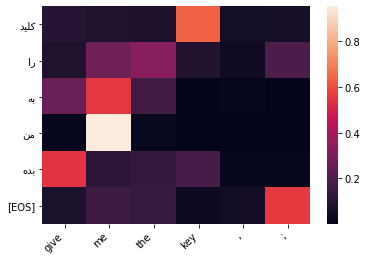

To add persian text to the plot you'll need the following line to repair the encoding issues:
```
get_display( arabic_reshaper.reshape( your text ))
```

In [ ]:
!pip install arabic_reshaper python-bidi

In [ ]:
import arabic_reshaper
import matplotlib.pyplot as plt
from seaborn import heatmap
from bidi.algorithm import get_display

def visualize_map(en_sentence):
  encoded_en = ### Implement this
  input_dict = {
    "ids": np.array(""" Implement this """]),
    "mask": np.array(""" Implement this """])
  }
  decoded_ids, attention_map = ### Implement this

  ### plotting the attention map
  # ------------------
  # Put your implementation here   
  # ------------------

In [ ]:
### Run without change
sample_sentences_ids = [13205, 13208, 21428, 300223, 432110]

for id in sample_sentences_ids:
  visualize_map(en[id])

# Submission

Congratulations! You finished the assignment & you're ready to submit your work. Please follow the instructions:

1. Check and review your answers. Make sure all of the cell outputs are what you want. 
2. Select File > Save.
3. **Fill your information** & run the cell bellow.
4. Run **Make Submission** cell, It may take several minutes and it may ask you for your credential.
5. Run **Download Submission** cell to obtain your submission as a zip file.
6. Grab the downloaded file (`nlp_asg03__xx__xx.zip`) and hand it over in microsoft teams.

## Fill your information (Run the cell)

In [ ]:
#@title Enter your information & "RUN the cell!!" { run: "auto" }
student_id = "" #@param {type:"string"}
student_name = "" #@param {type:"string"}

print("your student id:", student_id)
print("your name:", student_name)


from pathlib import Path

ASSIGNMENT_PATH = Path('asg03')
ASSIGNMENT_PATH.mkdir(parents=True, exist_ok=True)

## Make Submission (Run the cell)

In [ ]:
#@title Make submission
! pip install -U --quiet PyDrive > /dev/null
! pip install -U --quiet jdatetime > /dev/null

# ! wget -q https://github.com/github/hub/releases/download/v2.10.0/hub-linux-amd64-2.10.0.tgz 


import os
import time
import yaml
import json
import jdatetime

from google.colab import files
from IPython.display import Javascript
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

asg_name = 'NLP_Assignment_3'
script_save = '''
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});
'''
# repo_name = 'iust-deep-learning-assignments'
submission_file_name = 'nlp_asg02__%s__%s.zip'%(student_id, student_name.lower().replace(' ',  '_'))

sub_info = {
    'student_id': student_id,
    'student_name': student_name, 
    'dateime': str(jdatetime.date.today()),
    'asg_name': asg_name
}
json.dump(sub_info, open('info.json', 'w'))

Javascript(script_save)

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = drive.ListFile({'q':"title='%s.ipynb'"%asg_name}).GetList()[0]['id']
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('%s.ipynb'%asg_name) 

! jupyter nbconvert --to script "$asg_name".ipynb > /dev/null
! jupyter nbconvert --to html "$asg_name".ipynb > /dev/null
! zip "$submission_file_name" "$asg_name".ipynb "$asg_name".html "$asg_name".txt info.json > /dev/null

print("##########################################")
print("Done! Submisson created, Please download using the bellow cell!")


In [ ]:
drive.ListFile({'q':"title='%s.ipynb'"%asg_name}).GetList()[0]['id']

In [ ]:
files.download(submission_file_name)